In [9]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_hist, plot_pie, heatmap_from_df_cols
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/wa_external_appeals"
OUTPUT_DATA_DIR = "./output_data/wa_external_appeals"  # Set to None if you don't want to save non-required data for external use

In [10]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [11]:
# Manually grabbed yearly data from https://fortress.wa.gov/oic/consumertoolkit/Search.aspx?searchtype=indrev
# And renamed exports as below. This is annoyingly a manual step required to run this notebook for now.
# TODO: automate the data scraping.
dfs = []
for year in range(2016, 2023 + 1):
    year_df_path = os.path.join(INPUT_DATA_DIR, f"WAStateReviewDecision_{year}.csv")
    year_df = pd.read_csv(year_df_path)
    dfs.append(year_df)
df = pd.concat(dfs, ignore_index=True)
df.to_csv(os.path.join(OUTPUT_DATA_DIR, "wa_external_appeals.csv"), index=False)

In [12]:
YEAR_COL = "Year of Decision"
REVIEW_ORG_COL = "IRO Name"

# Remove two 1900 records, as it appears to be accidentally included, or a typo on date. Unclear what actual date is, so throw out record
df = df[df[YEAR_COL] != 1900]

In [13]:
print(f"This dataset contains a total of {len(df)} external appeals from WA.")
for year, count in df[YEAR_COL].value_counts(sort=False).items():
    print(f"\t{count} external appeals from {year}")

This dataset contains a total of 8774 external appeals from WA.
	955 external appeals from 2016
	1745 external appeals from 2018
	1318 external appeals from 2017
	1287 external appeals from 2019
	908 external appeals from 2020
	959 external appeals from 2021
	1102 external appeals from 2022
	500 external appeals from 2023


In [14]:
def get_overturn_rates_by_category(
    df: pd.DataFrame,
    cat_col: str,
    by_year: bool = False,
    outcome_col: str = "Outcome",
    upheld_cat_name: str = "Upheld",
    overturned_cat_name: str = "Overturned",
    year_cat_name: str = YEAR_COL,
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df[outcome_col].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get(overturned_cat_name, 0)
        decision_data[val]["overall"]["overturned"] = overturned
        decision_data[val]["overall"]["upheld"] = overturn_counts.get(
            upheld_cat_name, 0
        )
        decision_data[val]["overall"]["withdrew"] = overturn_counts.get(
            "Insured Withdrew", 0
        )
        decision_data[val]["overall"]["overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df[year_cat_name].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df[year_cat_name] == year]
                overturn_counts = sub_df[outcome_col].value_counts()
                overturned = overturn_counts.get(overturned_cat_name, 0)
                decision_data[val][year]["upheld"] = overturn_counts.get(
                    upheld_cat_name, 0
                )
                decision_data[val][year]["overturned"] = overturned
                decision_data[val][year]["withdrew"] = overturn_counts.get(
                    "Insured Withdrew", None
                )
                decision_data[val][year]["overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
    return decision_data


def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were overturned."
    )
    return None

In [15]:
appeal_decision_counts = df["Outcome"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Withdrawn by the Carrier', 'IRO Unavailable', 'Withdrawn by the Enrollee']
68% of all original determinations in external appeals were upheld
25% of all original determinations in external appeals were overturned.


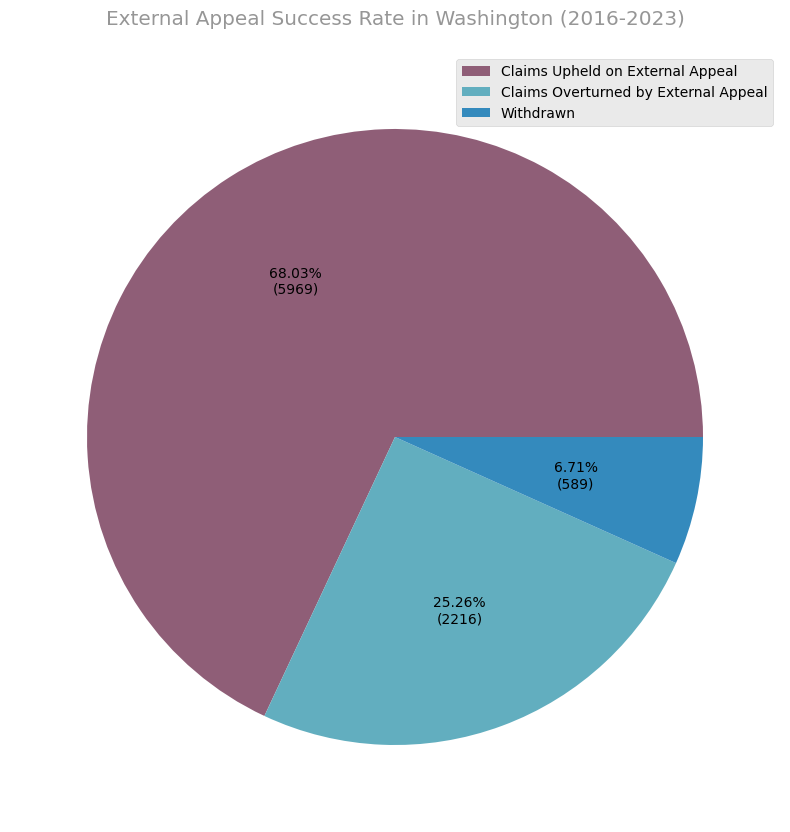

In [16]:
claims_externally_appealed = (
    appeal_decision_counts["Upheld"]
    + appeal_decision_counts["Overturned"]
    + appeal_decision_counts["Withdrawn by the Carrier"]
    + appeal_decision_counts["IRO Unavailable"]
    + appeal_decision_counts["Withdrawn by the Enrollee"]
)
claims_externally_overturned = appeal_decision_counts["Overturned"]
claims_externally_upheld = appeal_decision_counts["Upheld"]
other = (
    claims_externally_appealed - claims_externally_overturned - claims_externally_upheld
)
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
        "Withdrawn",
    ],
    slice_vals=[claims_externally_upheld, claims_externally_overturned, other],
    title="External Appeal Success Rate in Washington (2016-2023)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

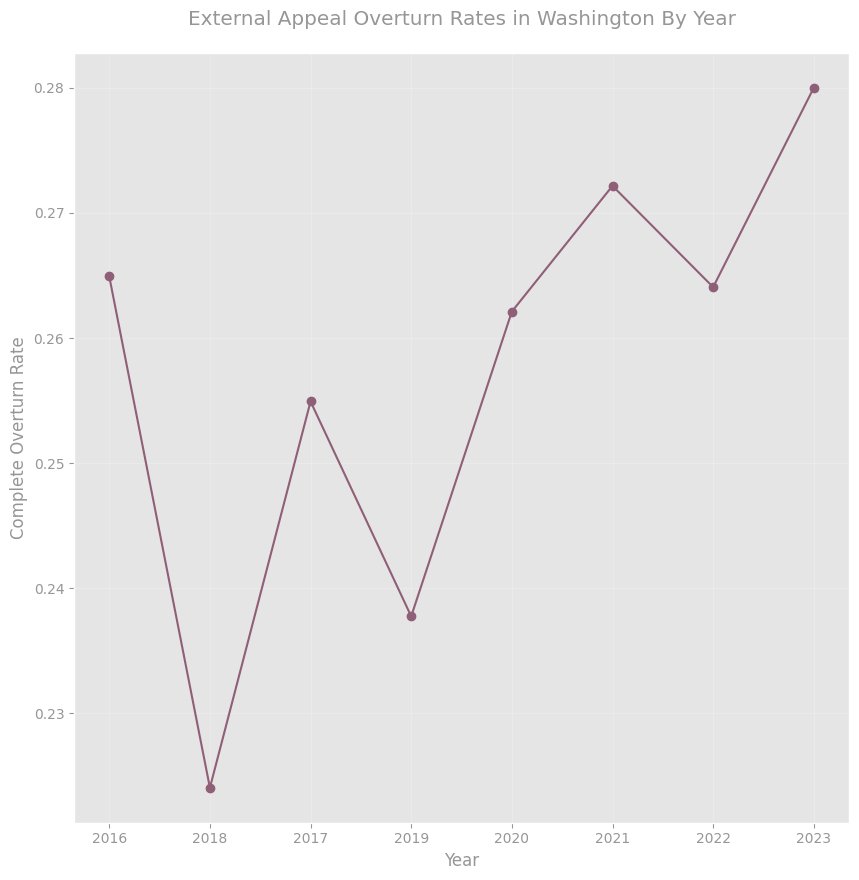

In [17]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, YEAR_COL)
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[YEAR_COL].unique())
ax.set_title("External Appeal Overturn Rates in Washington By Year")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

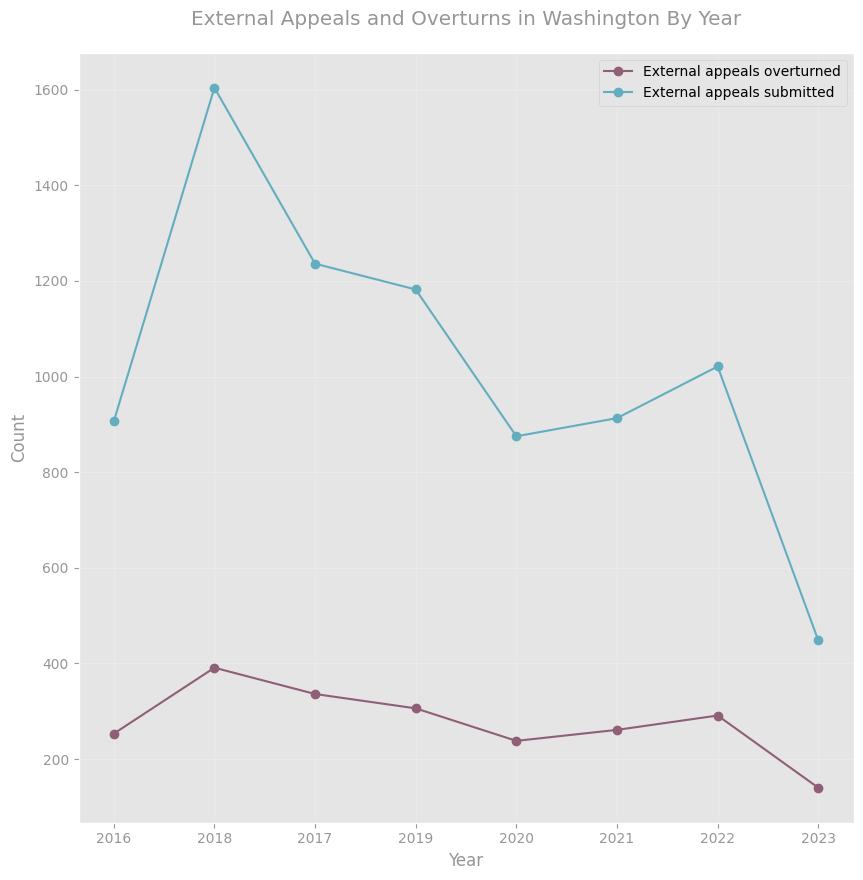

In [18]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[YEAR_COL].unique())
ax.set_title("External Appeals and Overturns in Washington By Year")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["overturned"] + year_data["withdrew"] + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, overturns_timeseries, "o-", label="External appeals overturned")
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

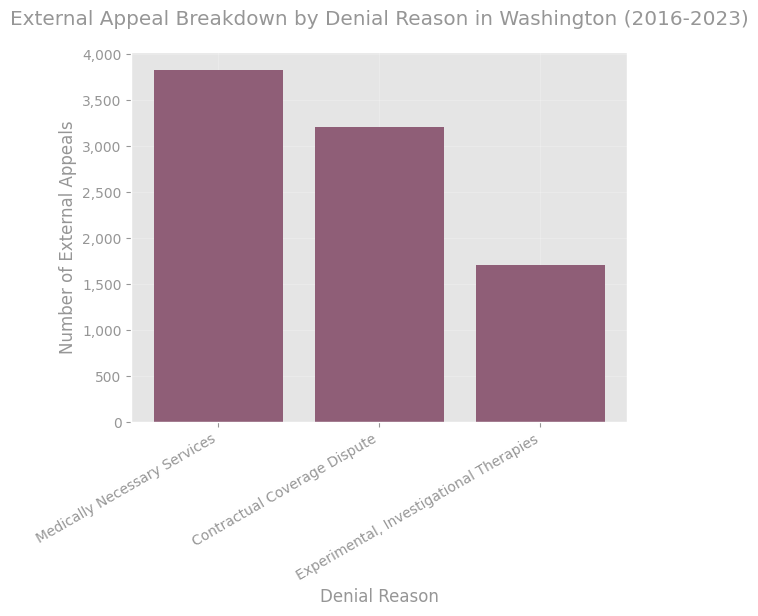

In [19]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeal Breakdown by Denial Reason in Washington (2016-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Reason"
denial_val_counts = df["Reason for request"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
)

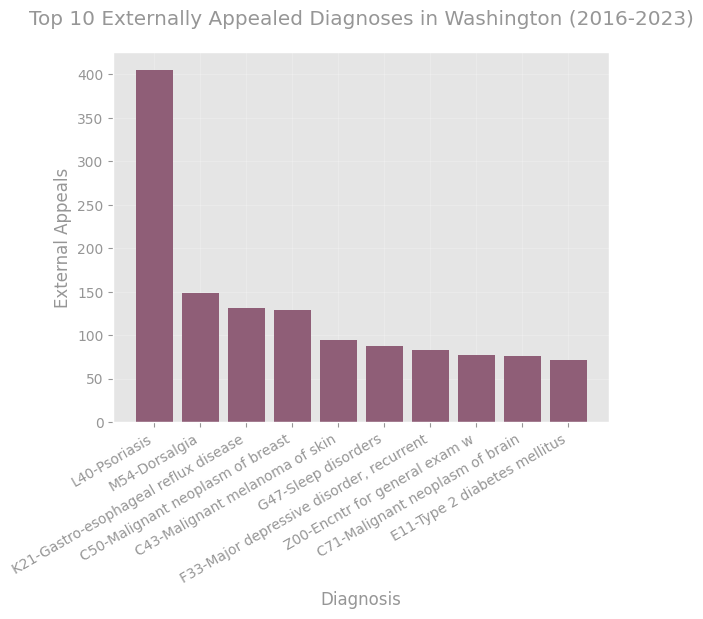

In [20]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses in Washington (2016-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
)

In [21]:
decision_data = get_overturn_rates_by_category(df, "CompanyName")
MIN_APPEALS = 150
bar_names = []
bar_vals = []
for k, v in decision_data.items():
    v = v["overall"]
    if v["overturned"] + v["upheld"] + v["withdrew"] > MIN_APPEALS:
        bar_vals.append(v["overturn_rate"])
        bar_names.append(k)
bar_names, bar_vals = zip(
    *sorted(zip(bar_names, bar_vals), reverse=True, key=lambda x: x[1])
)

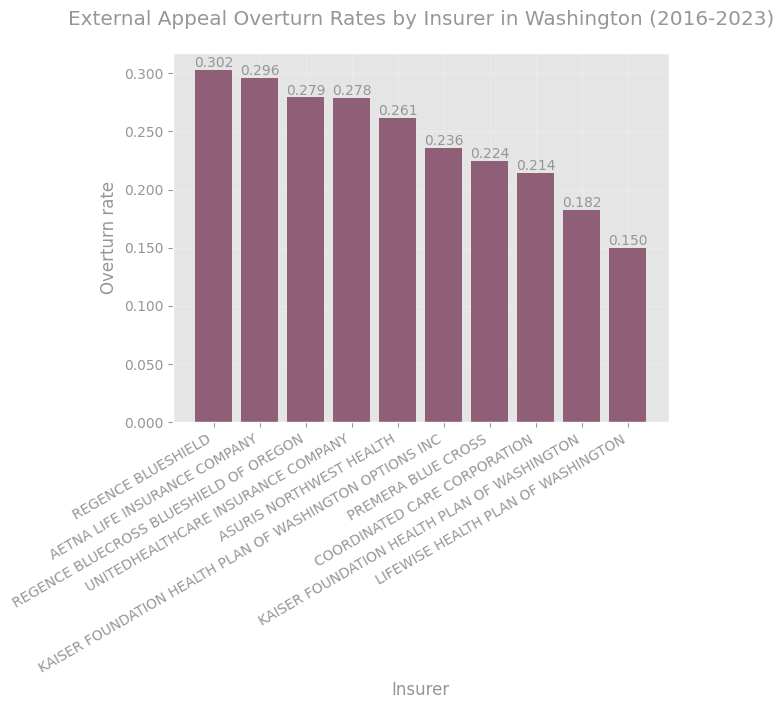

In [22]:
# Breakdown Appeal Overturn Rates by Insurer (for those with > MIN_APPEALS cases)
title = "External Appeal Overturn Rates by Insurer in Washington (2016-2023)"
val_axis_label = "Overturn rate"
cat_axis_label = "Insurer"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overturn_rates_by_insurer.png"),
    bar_label=True,
    int_vals=False,
)

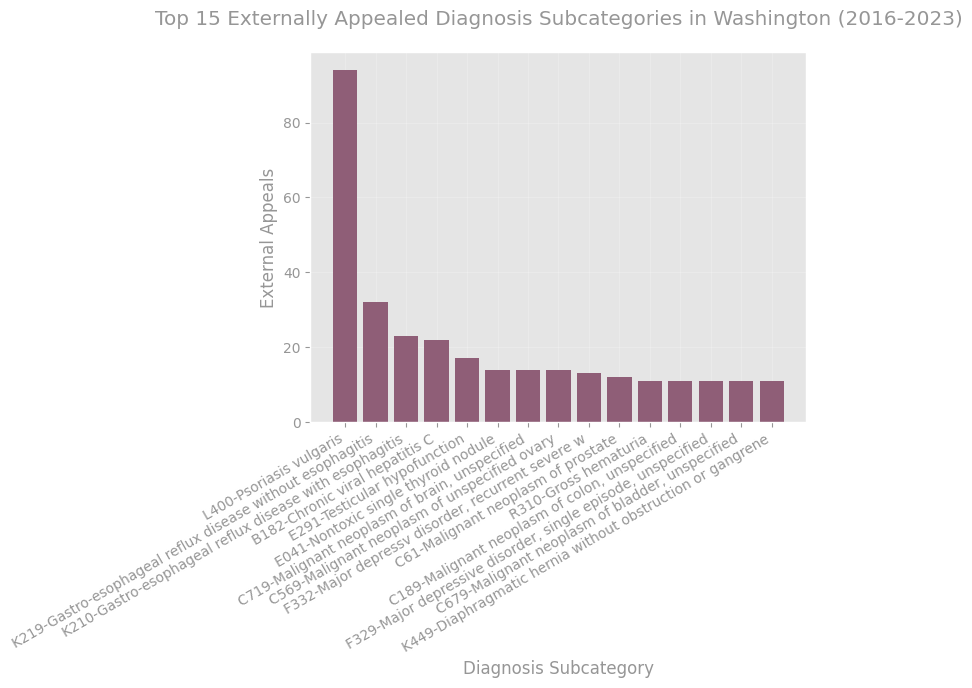

In [23]:
# Diagnosis breakdowns
n = 15
title = f"Top {n} Externally Appealed Diagnosis Subcategories in Washington (2016-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Subcategory"
subdiagnosis_val_counts = df["Diagnosis Subcategory"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(subdiagnosis_val_counts.index)
], subdiagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnosis_subcategories.png"
    ),
)

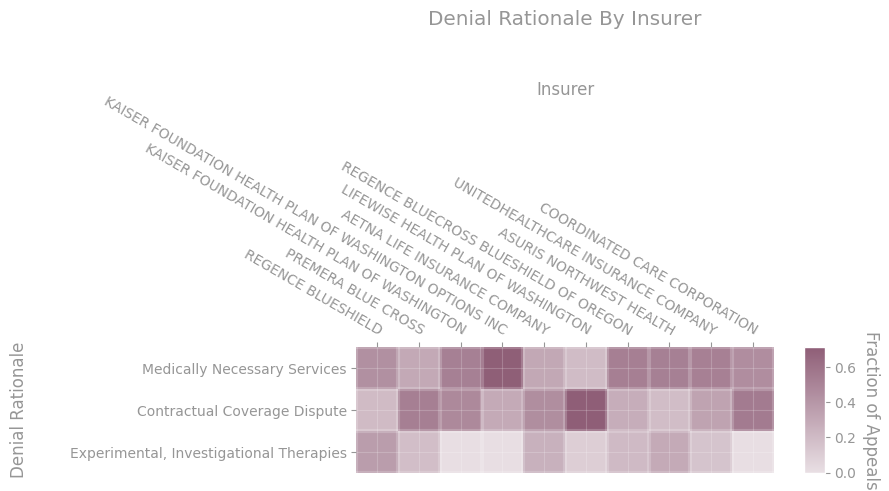

In [24]:
heatmap_from_df_cols(
    df,
    col1="Reason for request",
    col2="CompanyName",
    top_k1=3,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Denial Rationale By Insurer",
    x_label="Insurer",
    y_label="Denial Rationale",
    figsize=(9, 11),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rationale_by_insurer.png"),
)

In [25]:
agent_val_counts = df[REVIEW_ORG_COL].value_counts()

In [26]:
# Limit to top 5 by appeal counts, for plotting
agent_val_counts = agent_val_counts[agent_val_counts > 500]

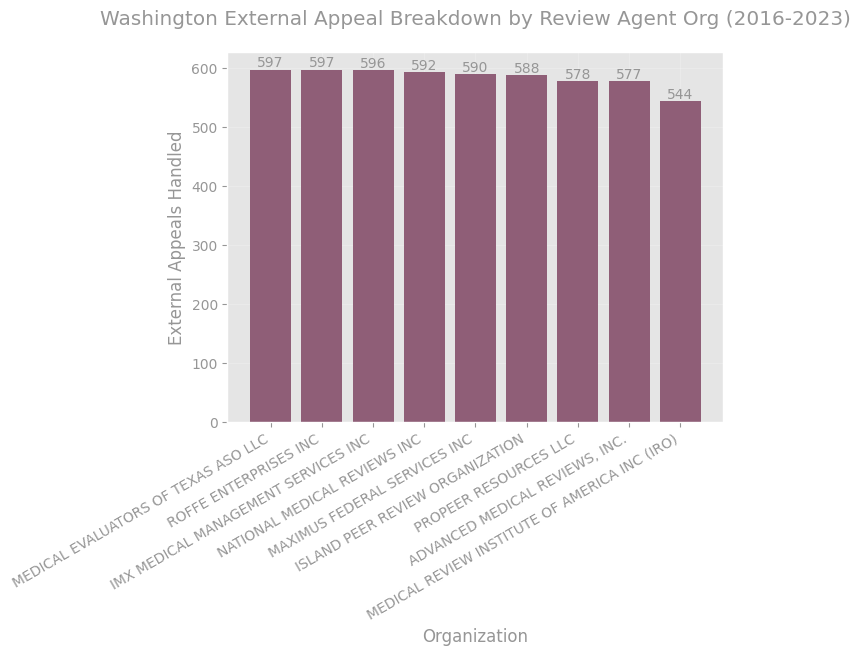

In [27]:
# Agent breakdowns
title = "Washington External Appeal Breakdown by Review Agent Org (2016-2023)"
val_axis_label = "External Appeals Handled"
cat_axis_label = "Organization"
bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_agent.png"),
    bar_label=True,
)

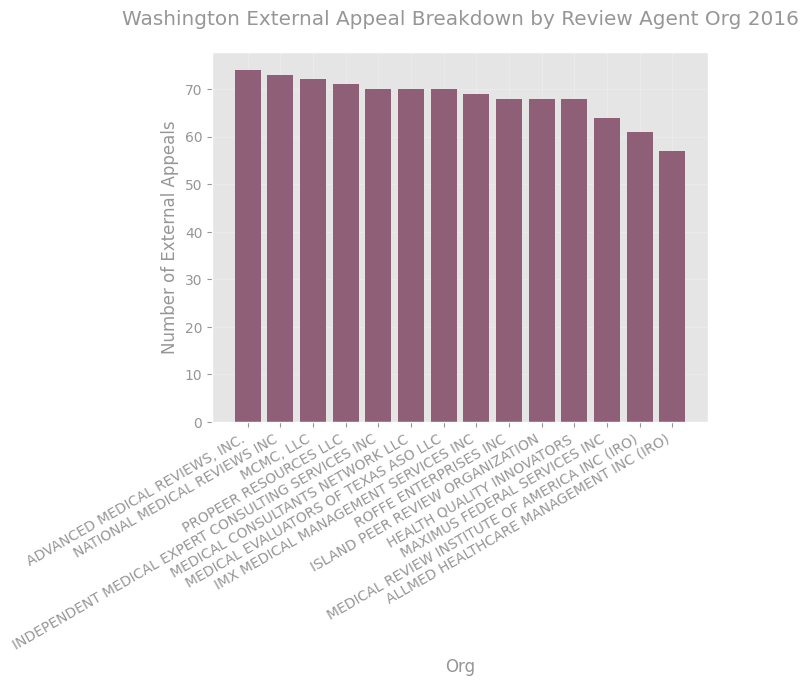

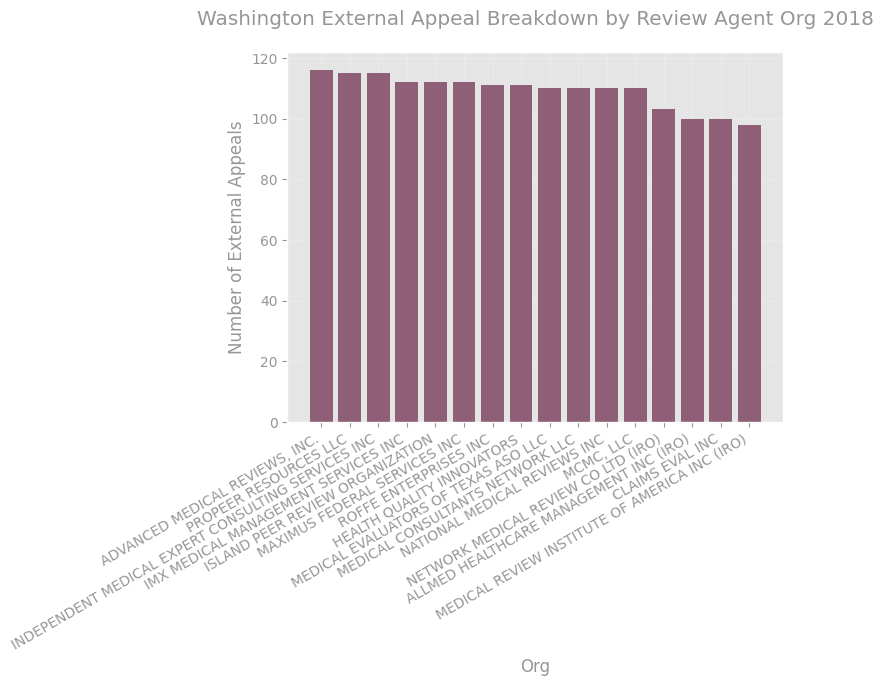

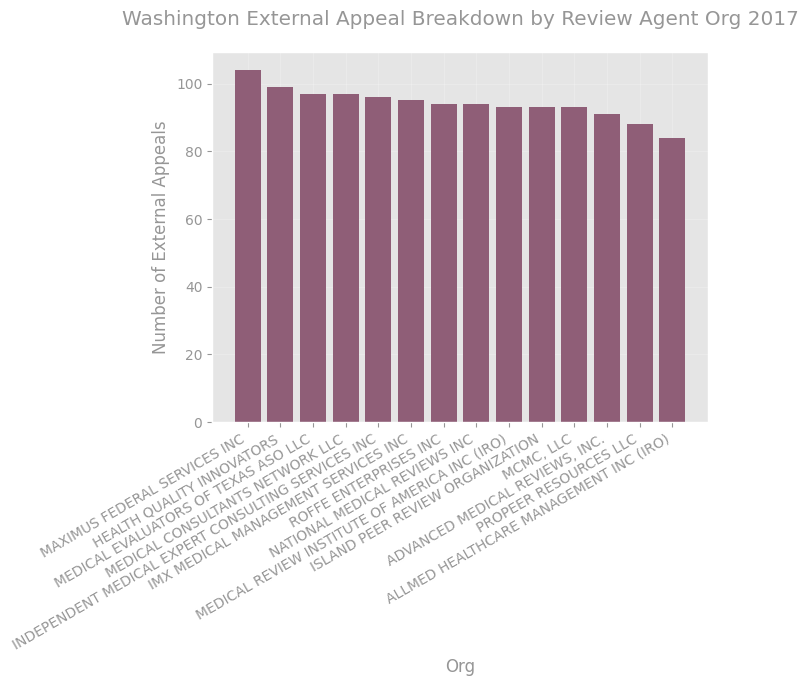

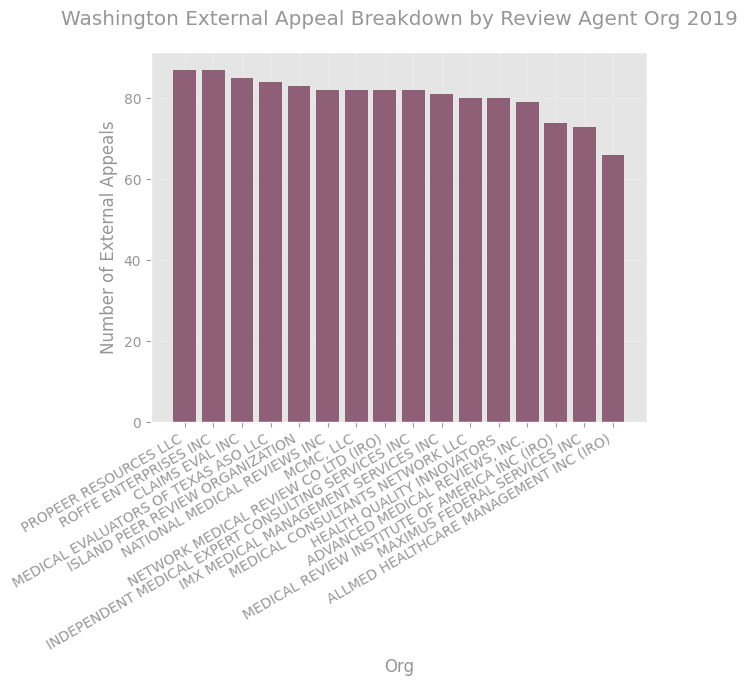

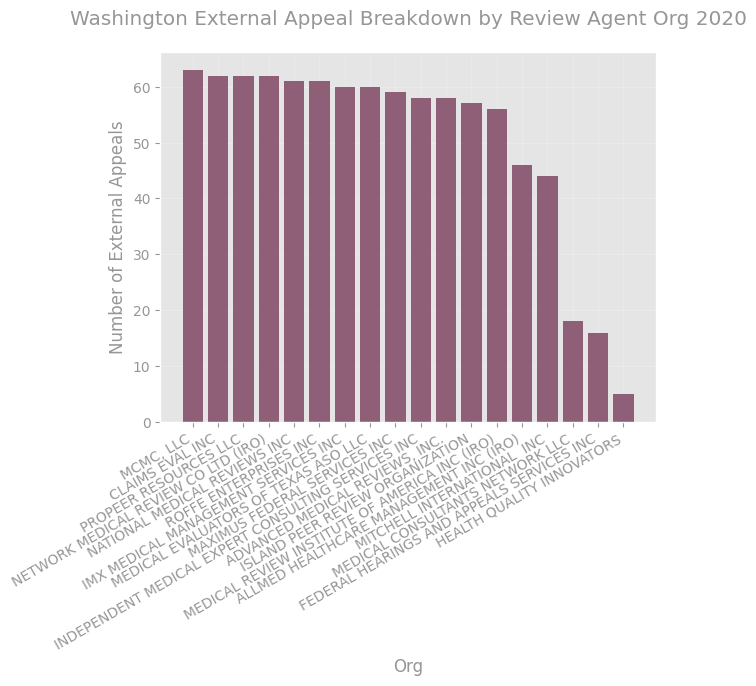

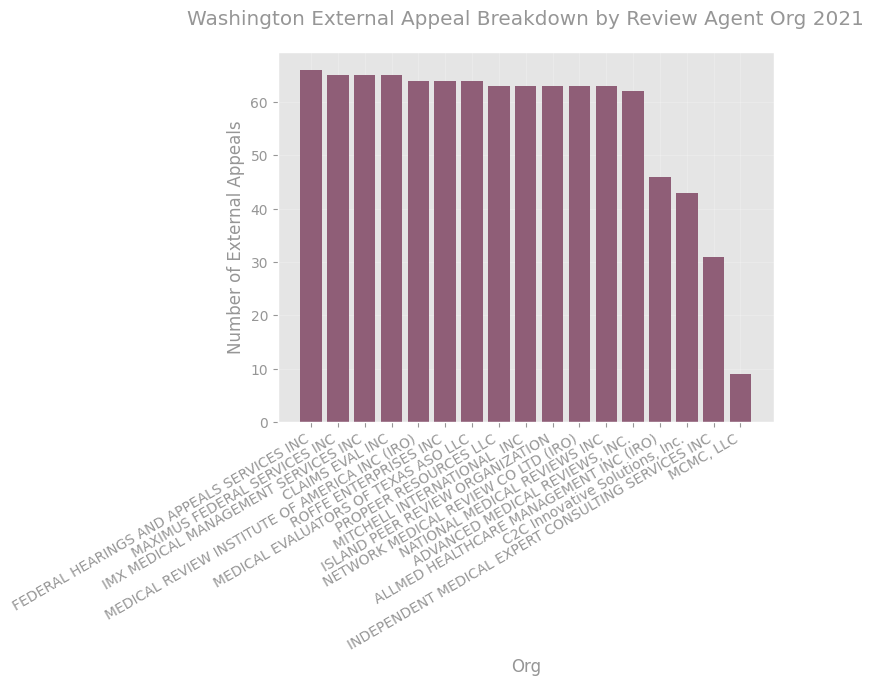

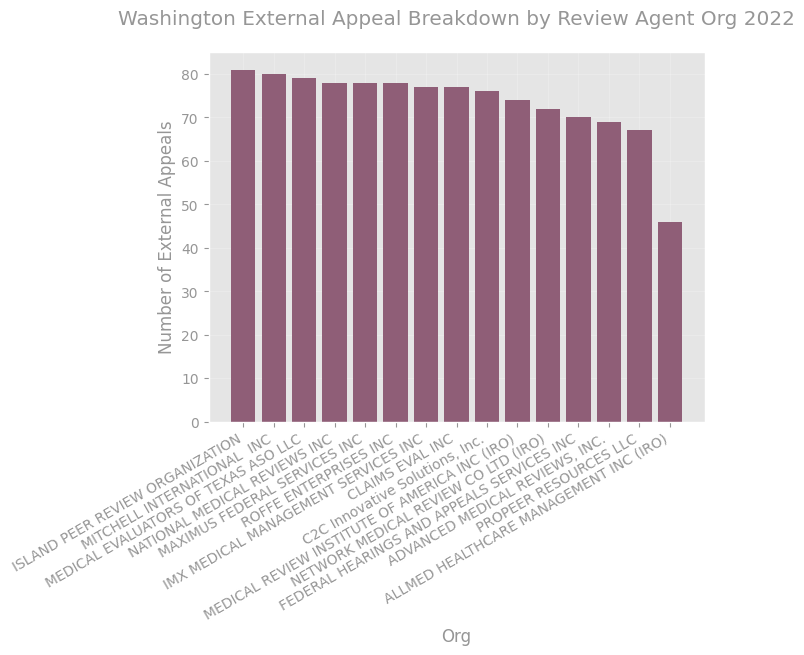

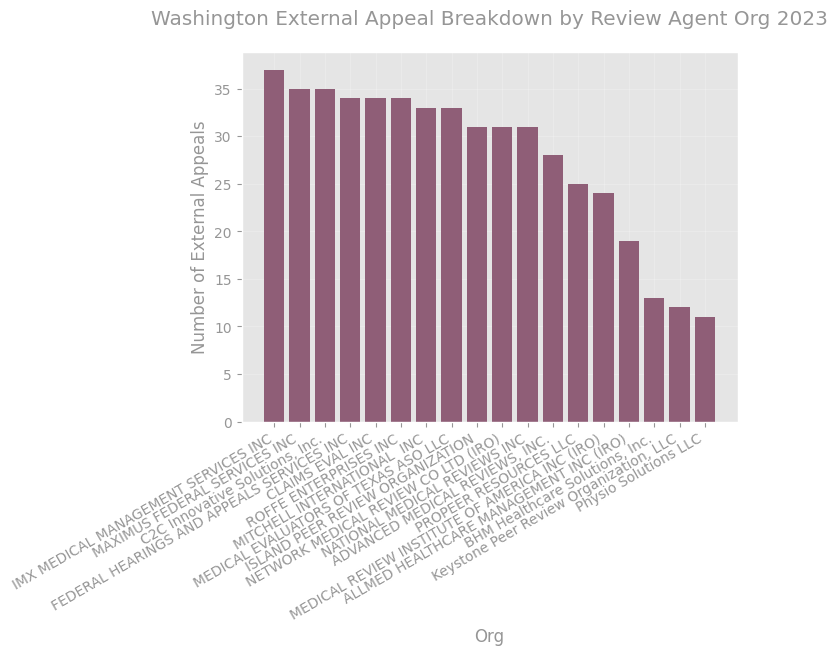

In [28]:
# Agent breakdowns by year
for year in df[YEAR_COL].unique():
    rel_df = df[df[YEAR_COL] == year]
    year_agent_val_counts = rel_df[REVIEW_ORG_COL].value_counts()
    title = f"Washington External Appeal Breakdown by Review Agent Org {year}"
    val_axis_label = "Number of External Appeals"
    cat_axis_label = "Org"
    bar_names, bar_vals = (
        list(year_agent_val_counts.index),
        year_agent_val_counts.values,
    )
    plot_bar(
        bar_names,
        bar_vals,
        title=title,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeals_by_agent_{year}.png"
        ),
        show=False,
    )

In [29]:
agent_decision_data = get_overturn_rates_by_category(
    df, cat_col=REVIEW_ORG_COL, by_year=True
)

In [30]:
agent_decision_data = {
    k: v for k, v in agent_decision_data.items() if k in agent_val_counts.index
}

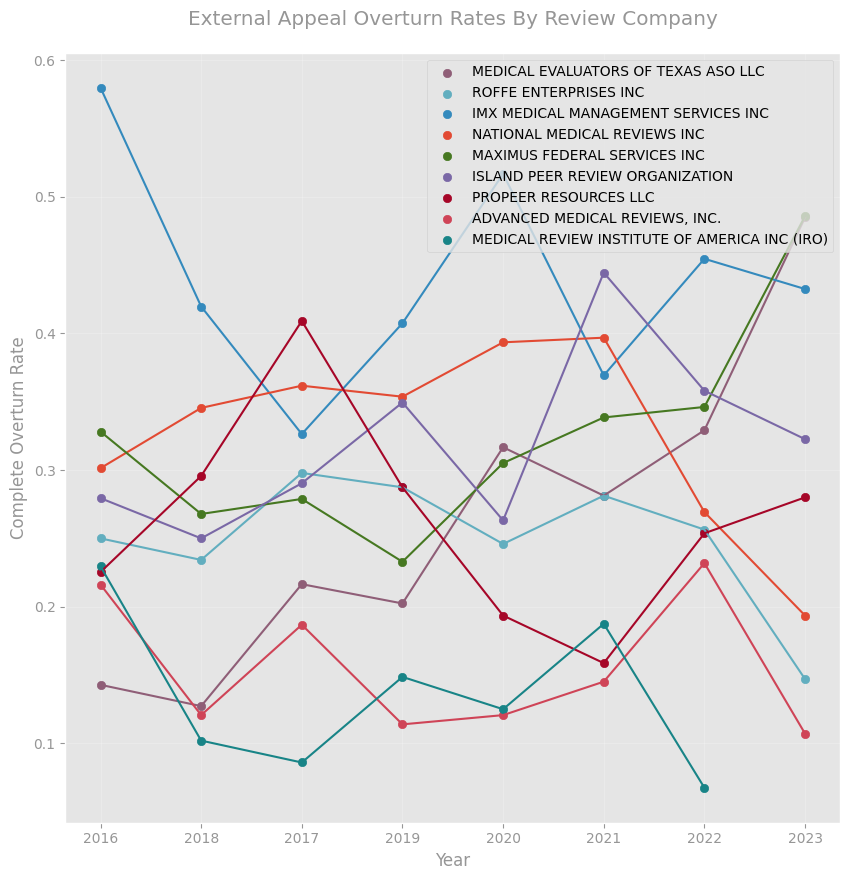

In [31]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df[YEAR_COL].unique())
ax.set_title("External Appeal Overturn Rates By Review Company")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for agent in agent_val_counts.keys():
    agent_timeseries = []
    for year in x:
        if agent_decision_data[agent].get(year, None):
            agent_timeseries.append(agent_decision_data[agent][year]["overturn_rate"])
        else:
            agent_timeseries.append(None)
    ax.scatter(dates, agent_timeseries, label=agent)
    ax.plot(dates, agent_timeseries)
ax.legend(labelcolor="black")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_review_org.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

In [32]:
bar_vals = []
bar_names = []
for agent in agent_val_counts.keys():
    bar_names.append(agent)
    bar_vals.append(agent_decision_data[agent]["overall"]["overturn_rate"])

bar_names, bar_vals = zip(*sorted(zip(bar_names, bar_vals), key=lambda x: x[1]))

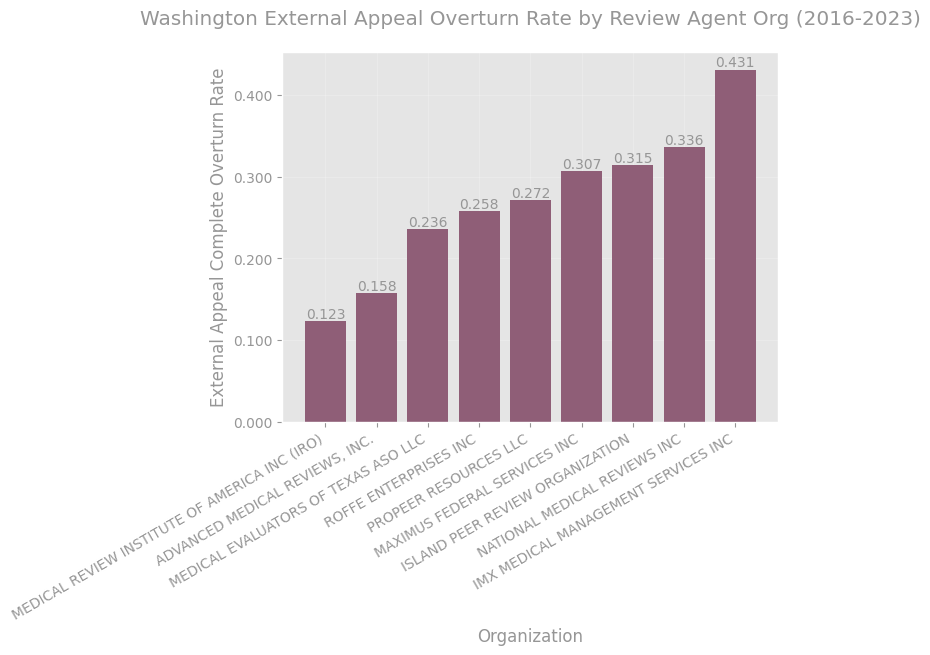

In [33]:
# Agent breakdowns overturn rates (averaged over years)
title = "Washington External Appeal Overturn Rate by Review Agent Org (2016-2023)"
val_axis_label = "External Appeal Complete Overturn Rate"
cat_axis_label = "Organization"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_agent.png"
    ),
    bar_label=True,
    int_vals=False,
)

Q: Who funds each of these orgs? How much money does each receive from services they sell to insurers, and how, if at all,
does that relate to their historical overturn rates?

### NMN / Experimental Specific Counts

In [34]:
# NMN / Experimental / Contractual
RATIONALE_CAT = "Reason for request"
rationale_df = df[~df[RATIONALE_CAT].isna()].copy()
rationale_decision_data = get_overturn_rates_by_category(
    rationale_df, RATIONALE_CAT, by_year=True
)

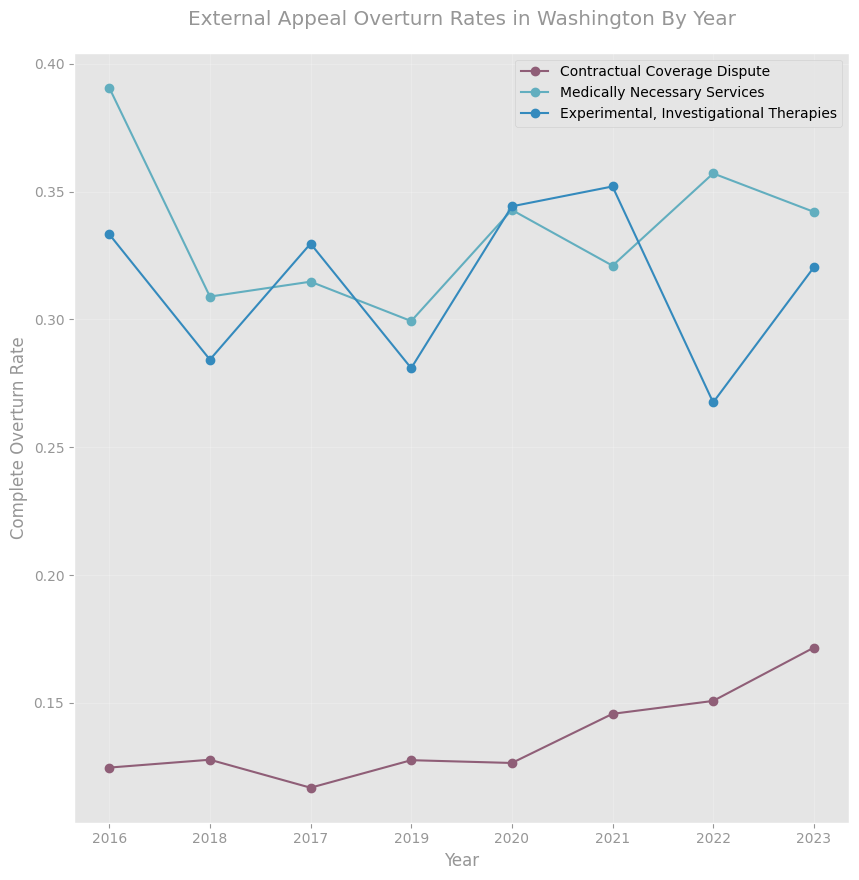

In [35]:
# Change over years
fig, ax = plt.subplots(figsize=(10, 10))
rationales = list(rationale_df[RATIONALE_CAT].unique())

ax.set_title("External Appeal Overturn Rates in Washington By Year")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
years = list(df[YEAR_COL].unique())
dates = np.asarray(years).astype(str)
for rationale in rationales:
    decision_data = rationale_decision_data[rationale]
    timeseries = []
    for year in years:
        if decision_data.get(year, None):
            timeseries.append(decision_data[year]["overturn_rate"])
        else:
            timeseries.append(None)
    ax.plot(dates, timeseries, "o-", label=rationale)

ax.legend(labelcolor="black")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_denial_rationale_by_year.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

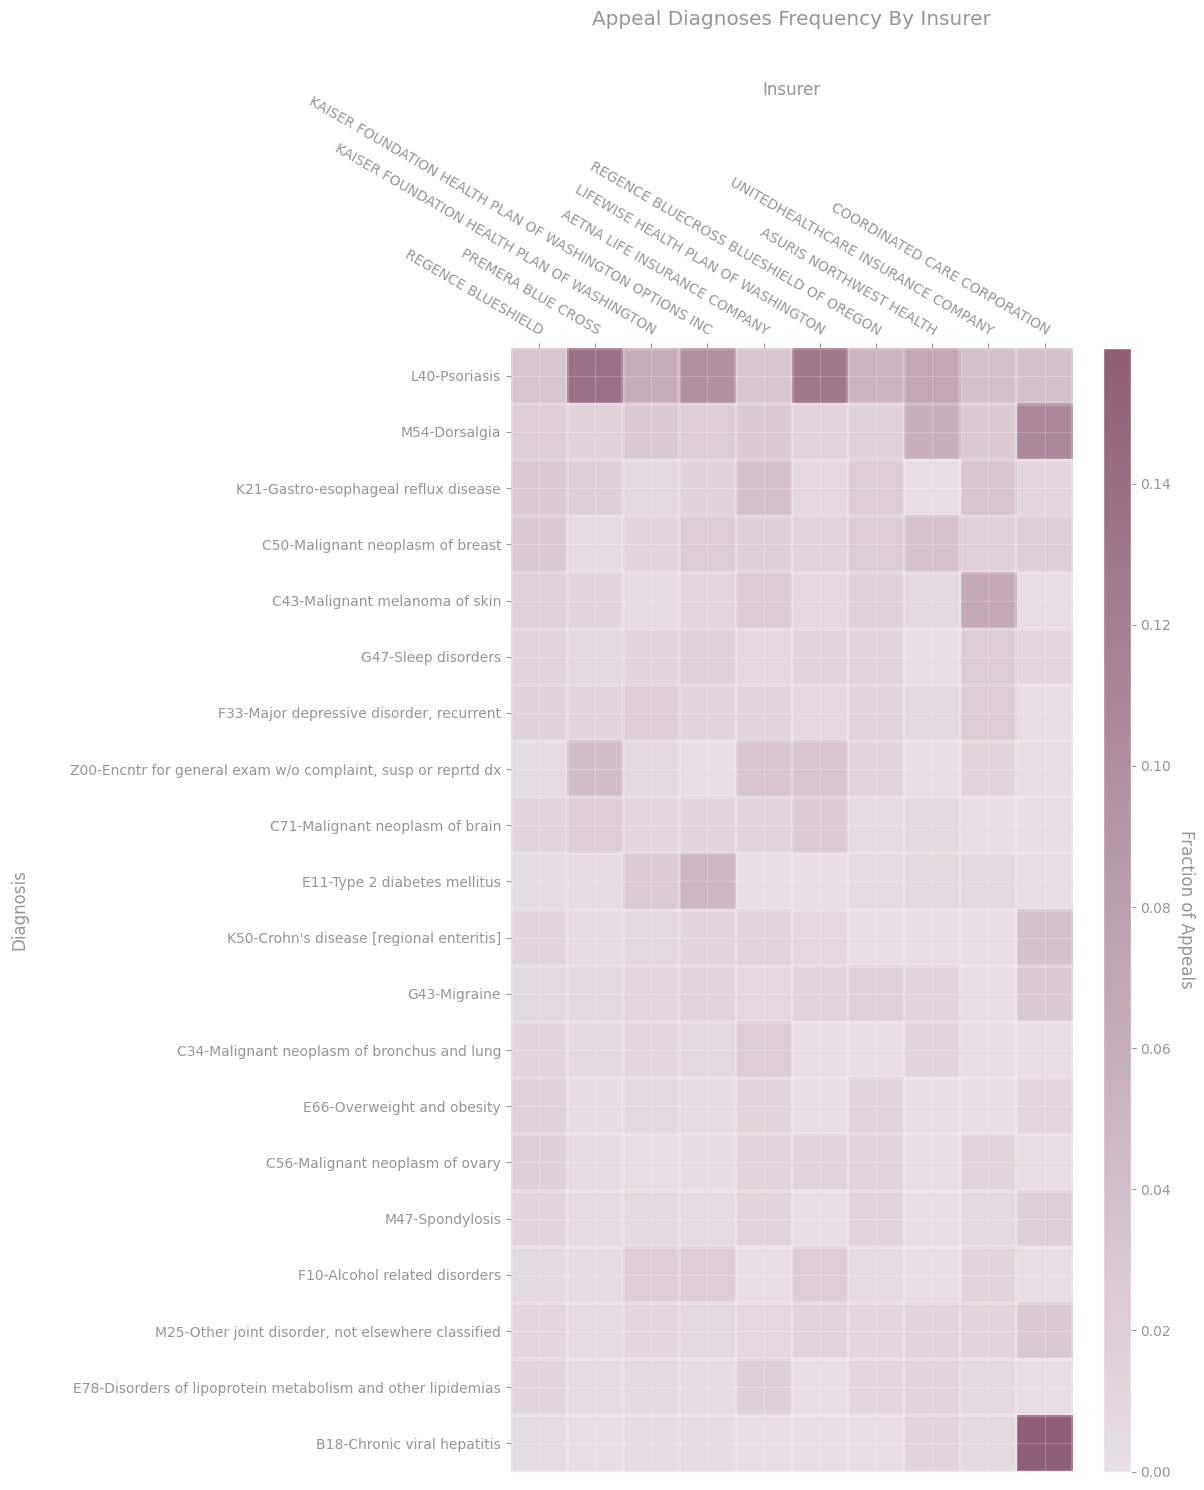

In [36]:
heatmap_from_df_cols(
    df,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Appeal Diagnoses Frequency By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "diagnosis_by_insurer.png"),
)

In [37]:
overturns = df[df["Outcome"] == "Overturned"]

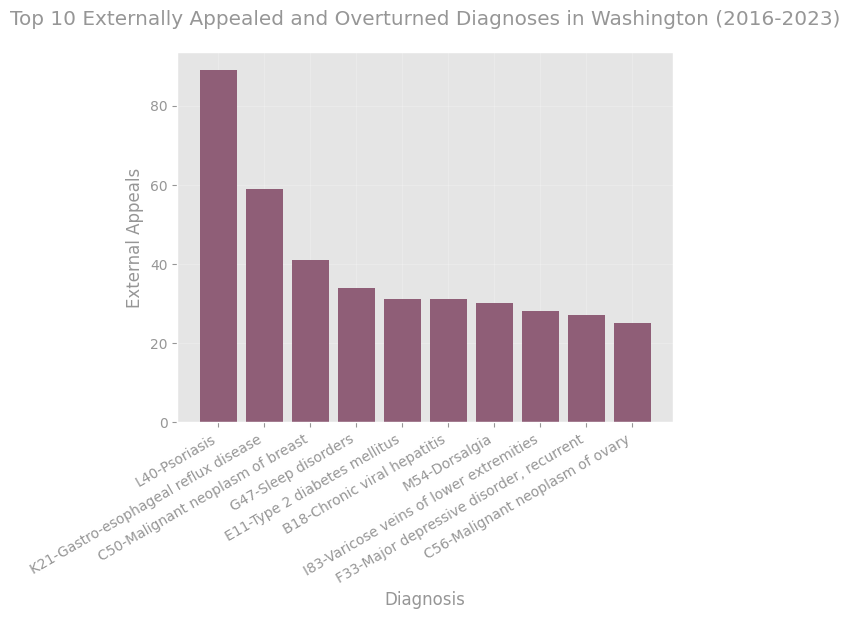

In [38]:
# Diagnosis breakdowns among overturns
n = 10
title = (
    f"Top {n} Externally Appealed and Overturned Diagnoses in Washington (2016-2023)"
)
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = overturns["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_diagnoses.png"),
)

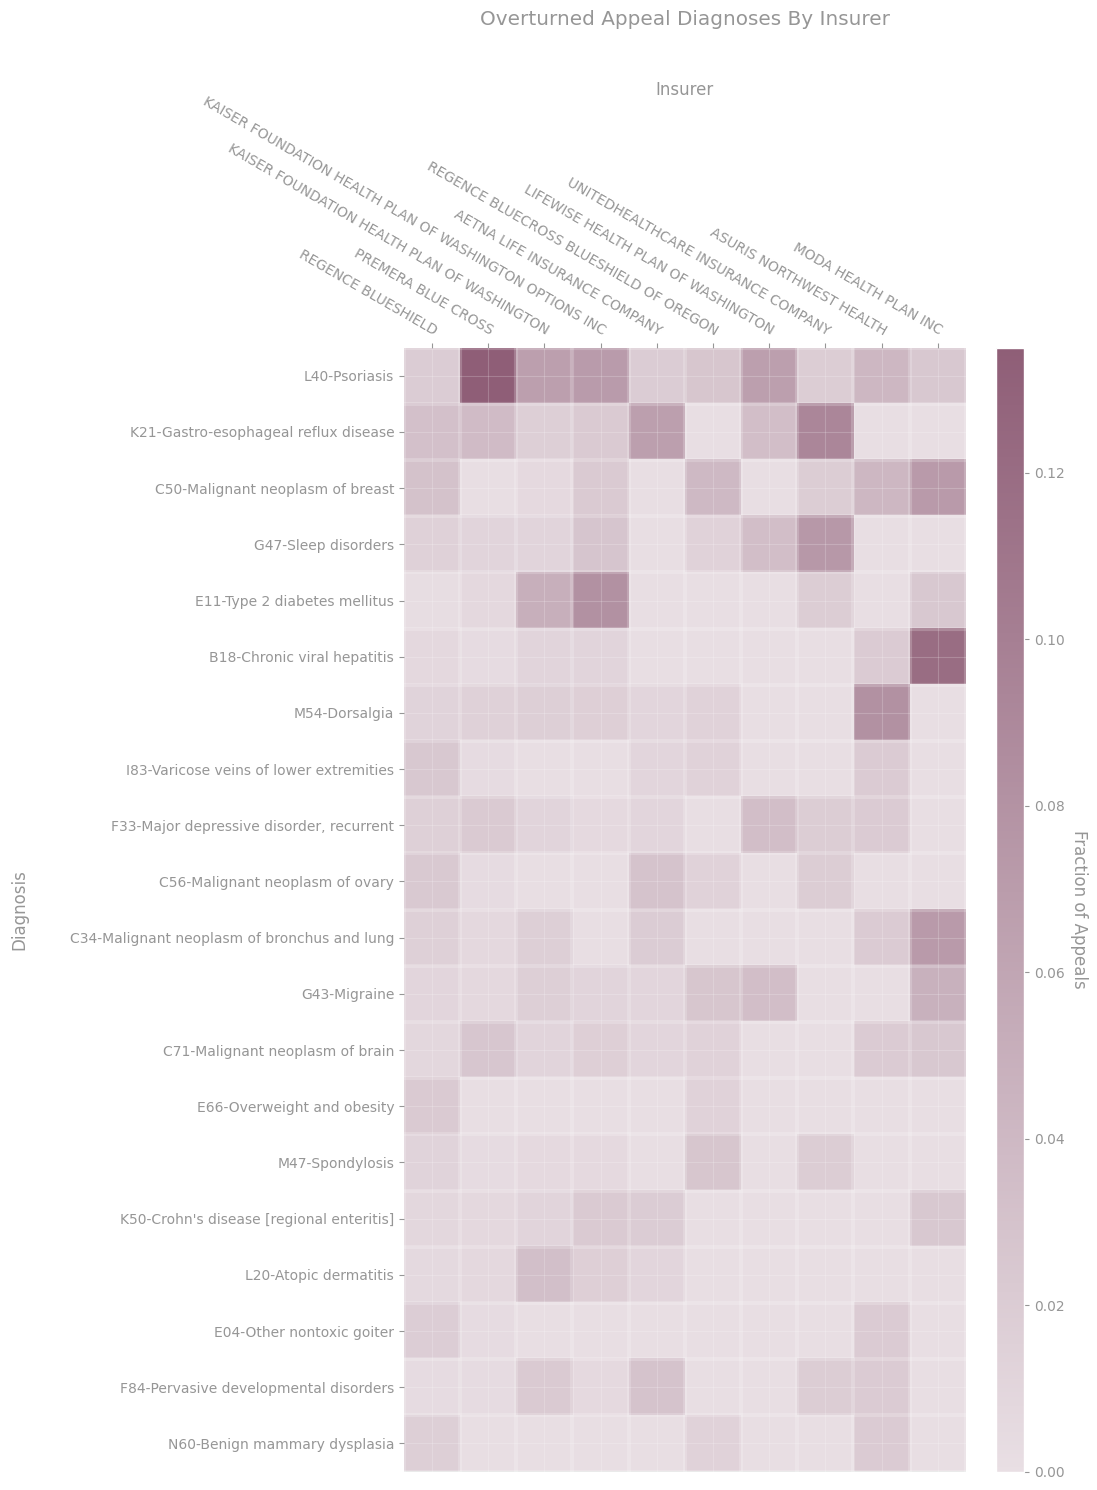

In [39]:
heatmap_from_df_cols(
    overturns,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Overturned Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overturned_diagnosis_by_insurer.png"),
)

In [40]:
nmn = df[df["Reason for request"] == "Medically Necessary Services"]
experimental = df[df["Reason for request"] == "Experimental, Investigational Therapies"]
contractual = df[df["Reason for request"] == "Contractual Coverage Dispute"]

overturned_nmn = nmn[nmn["Outcome"] == "Overturned"]
overturned_experimental = experimental[experimental["Outcome"] == "Overturned"]
overturned_contractual = contractual[contractual["Outcome"] == "Overturned"]

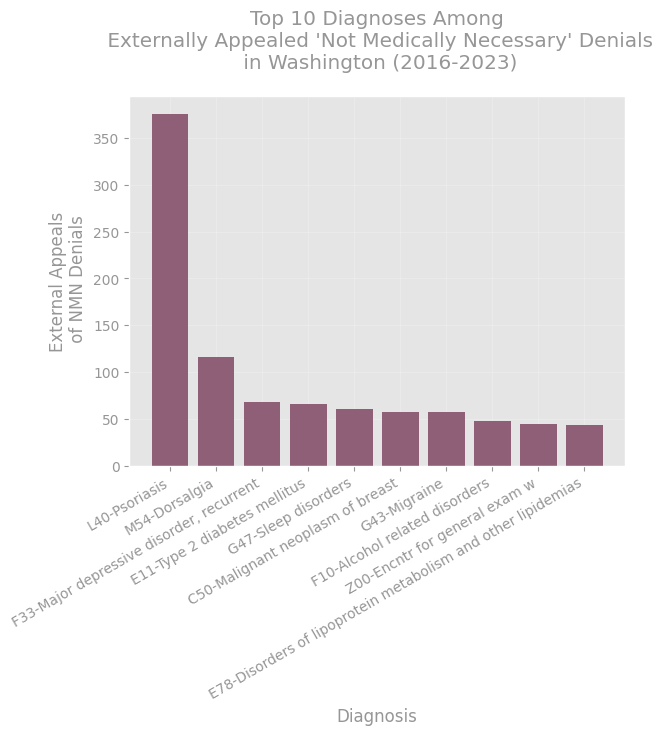

In [41]:
# Diagnosis breakdowns among NMN
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Not Medically Necessary' Denials\n in Washington (2016-2023)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = nmn["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmm_appeal_diagnoses.png"),
)

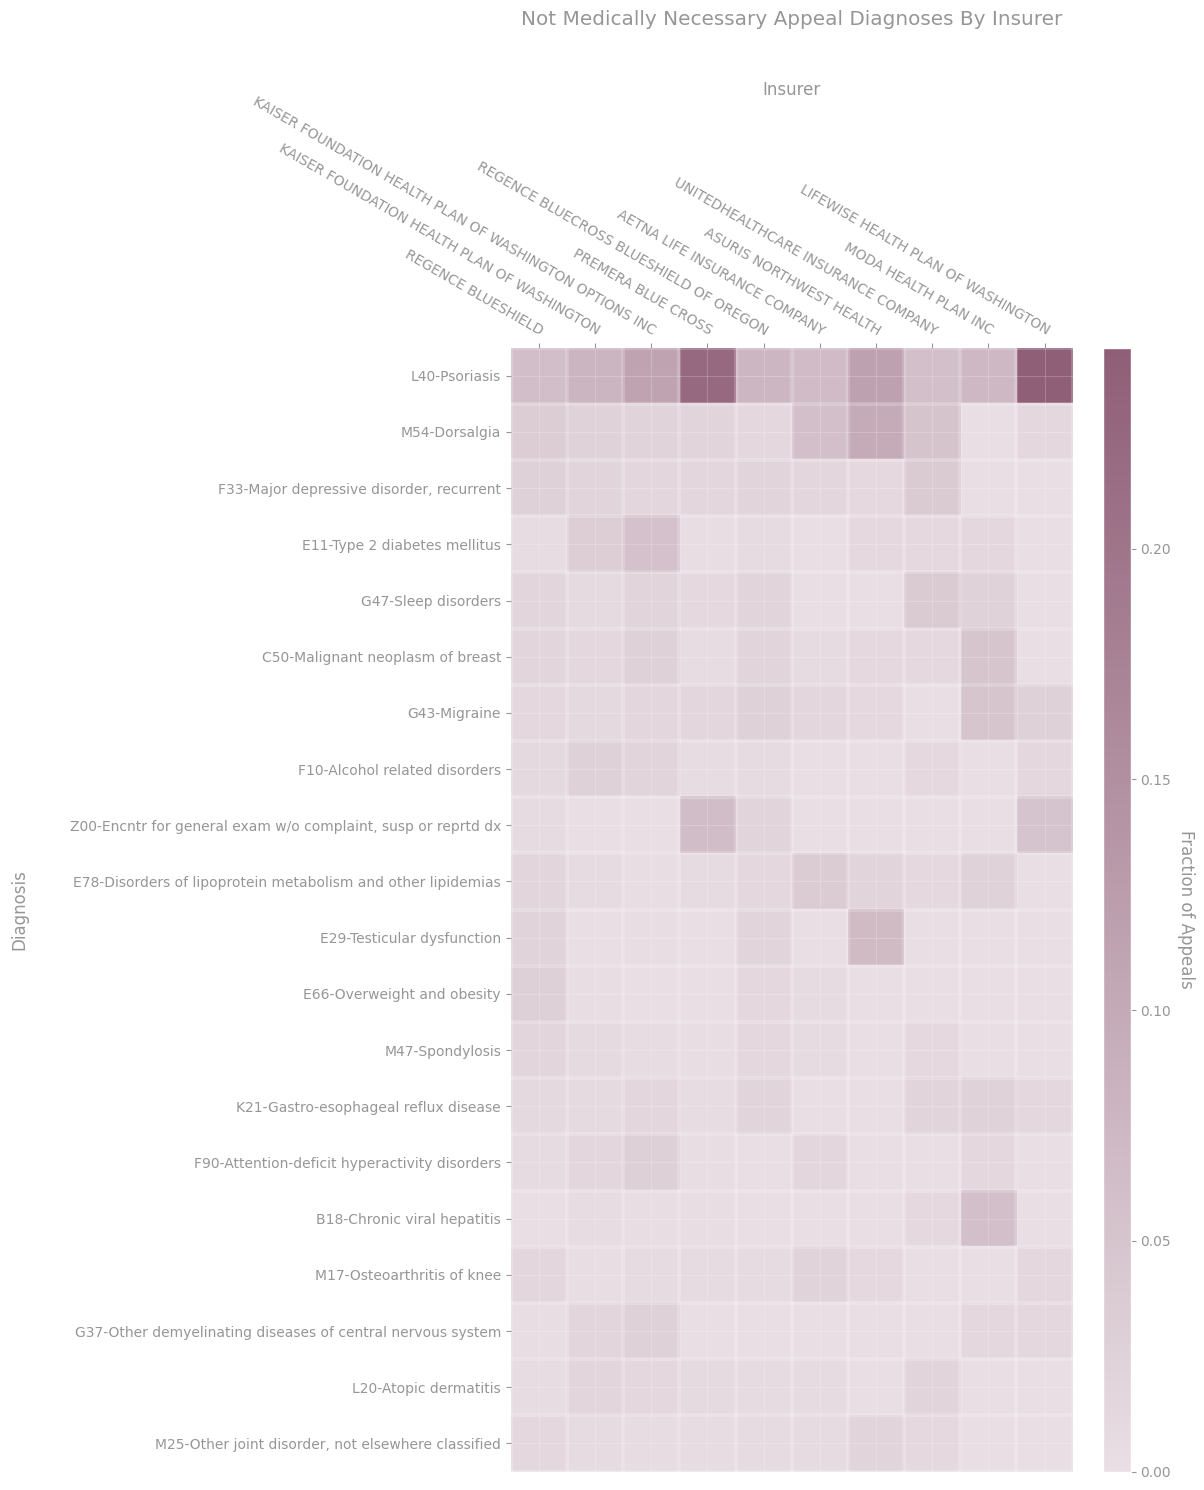

In [42]:
heatmap_from_df_cols(
    nmn,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Not Medically Necessary Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_diagnosis_by_insurer.png"),
)

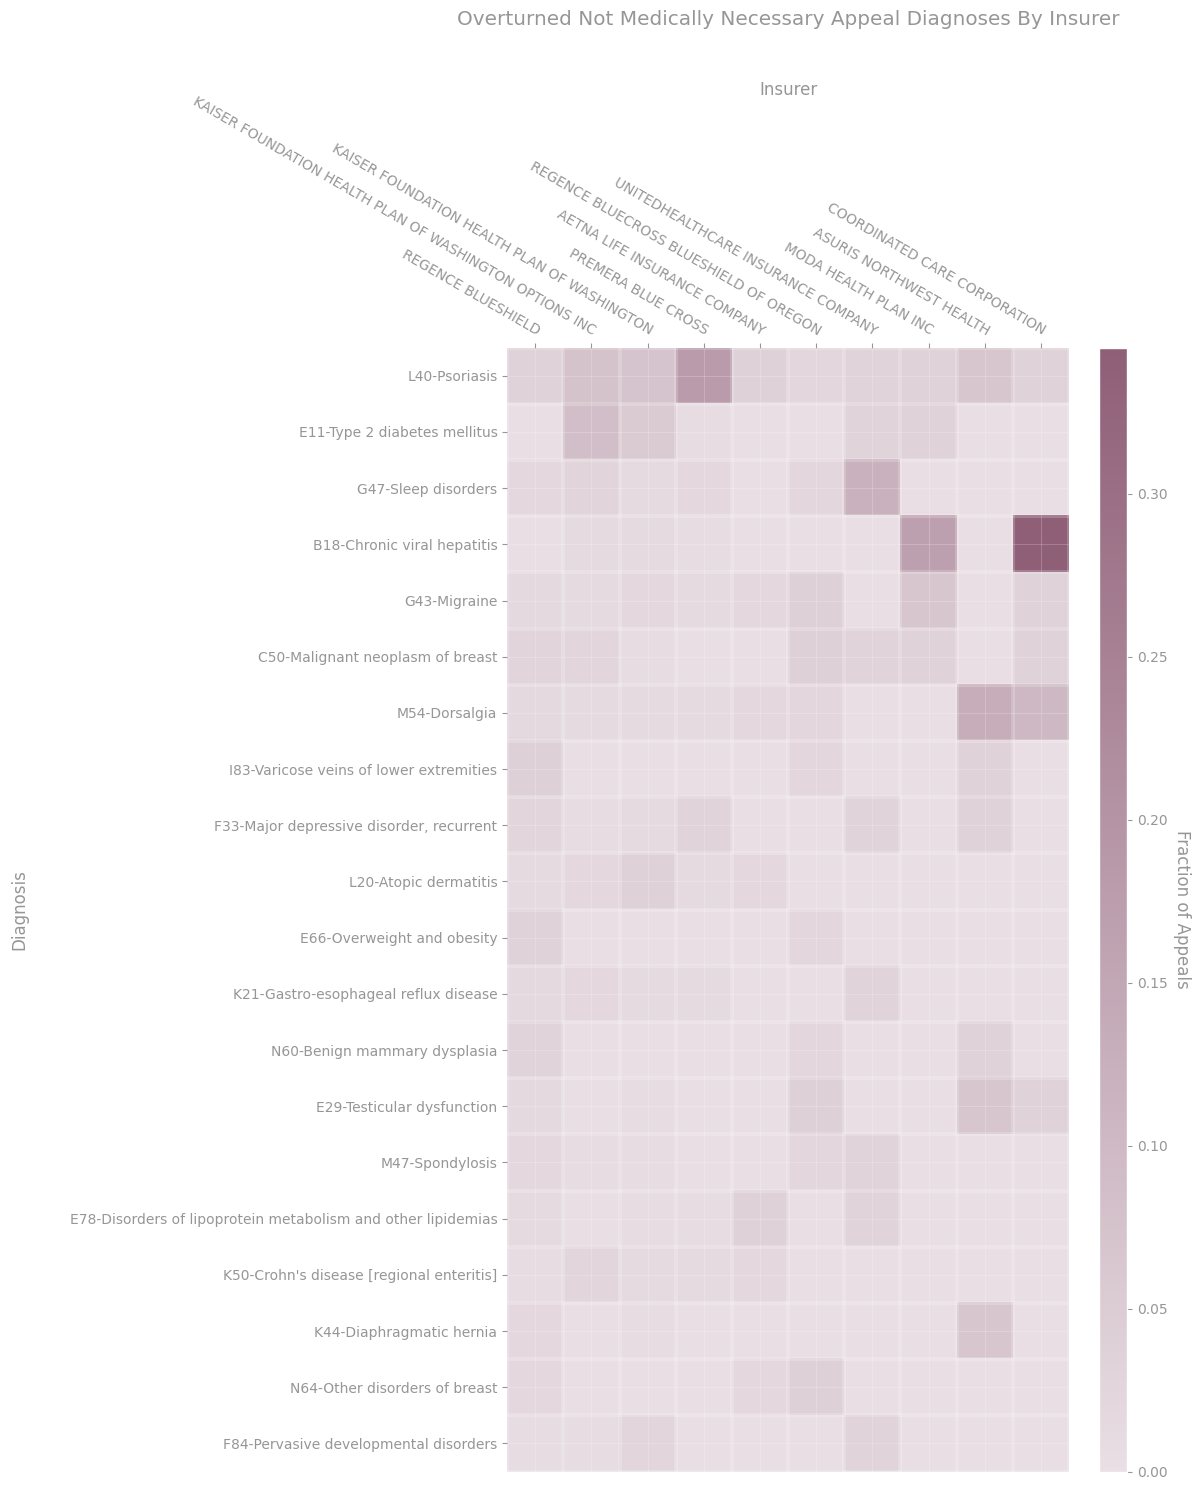

In [43]:
heatmap_from_df_cols(
    overturned_nmn,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Overturned Not Medically Necessary Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_overturned_diagnosis_by_insurer.png"),
)

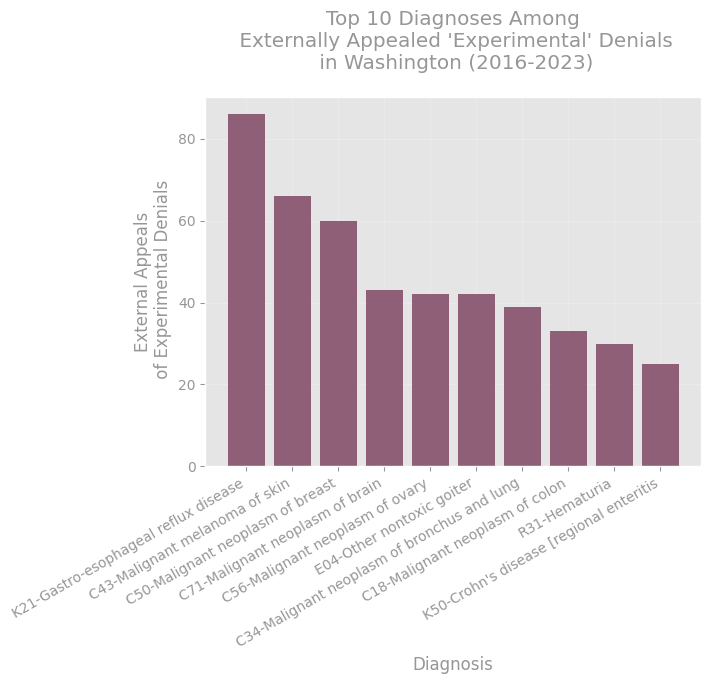

In [44]:
# Diagnosis breakdowns among Experimental Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Experimental' Denials\n in Washington (2016-2023)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = experimental["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_diagnoses.png"),
)

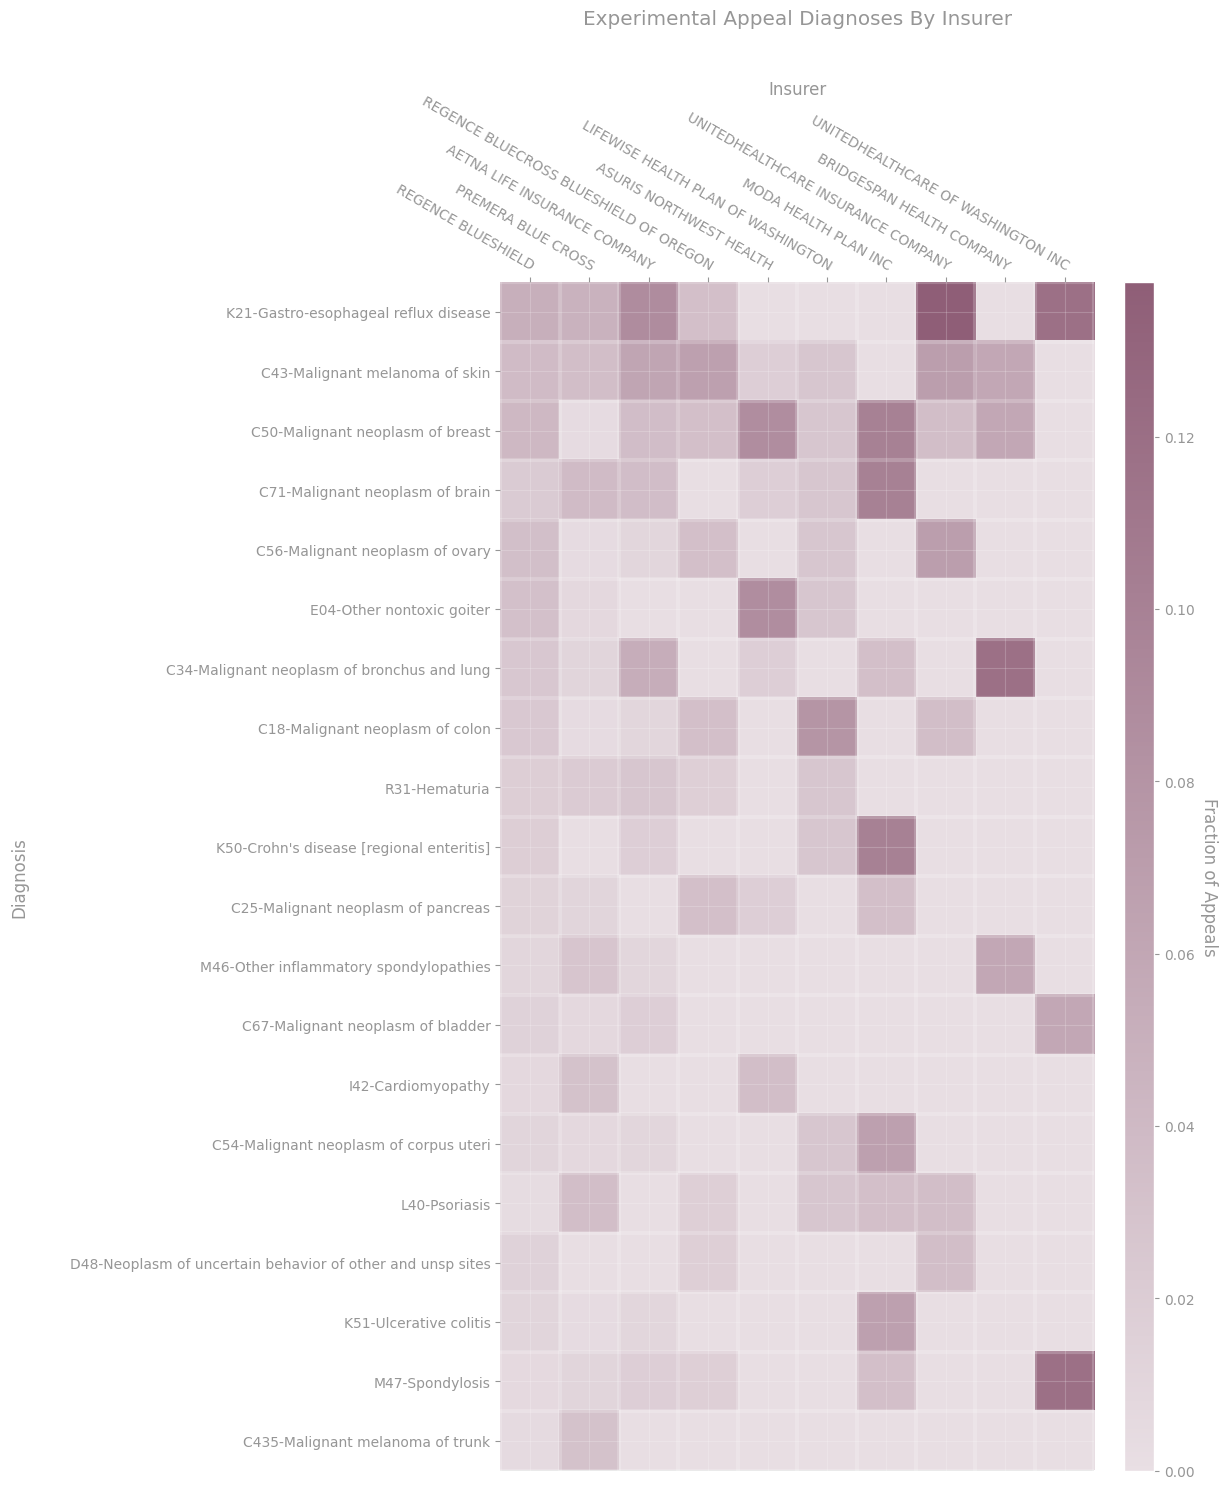

In [45]:
heatmap_from_df_cols(
    experimental,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Experimental Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "experimental_diagnosis_by_insurer.png"),
)

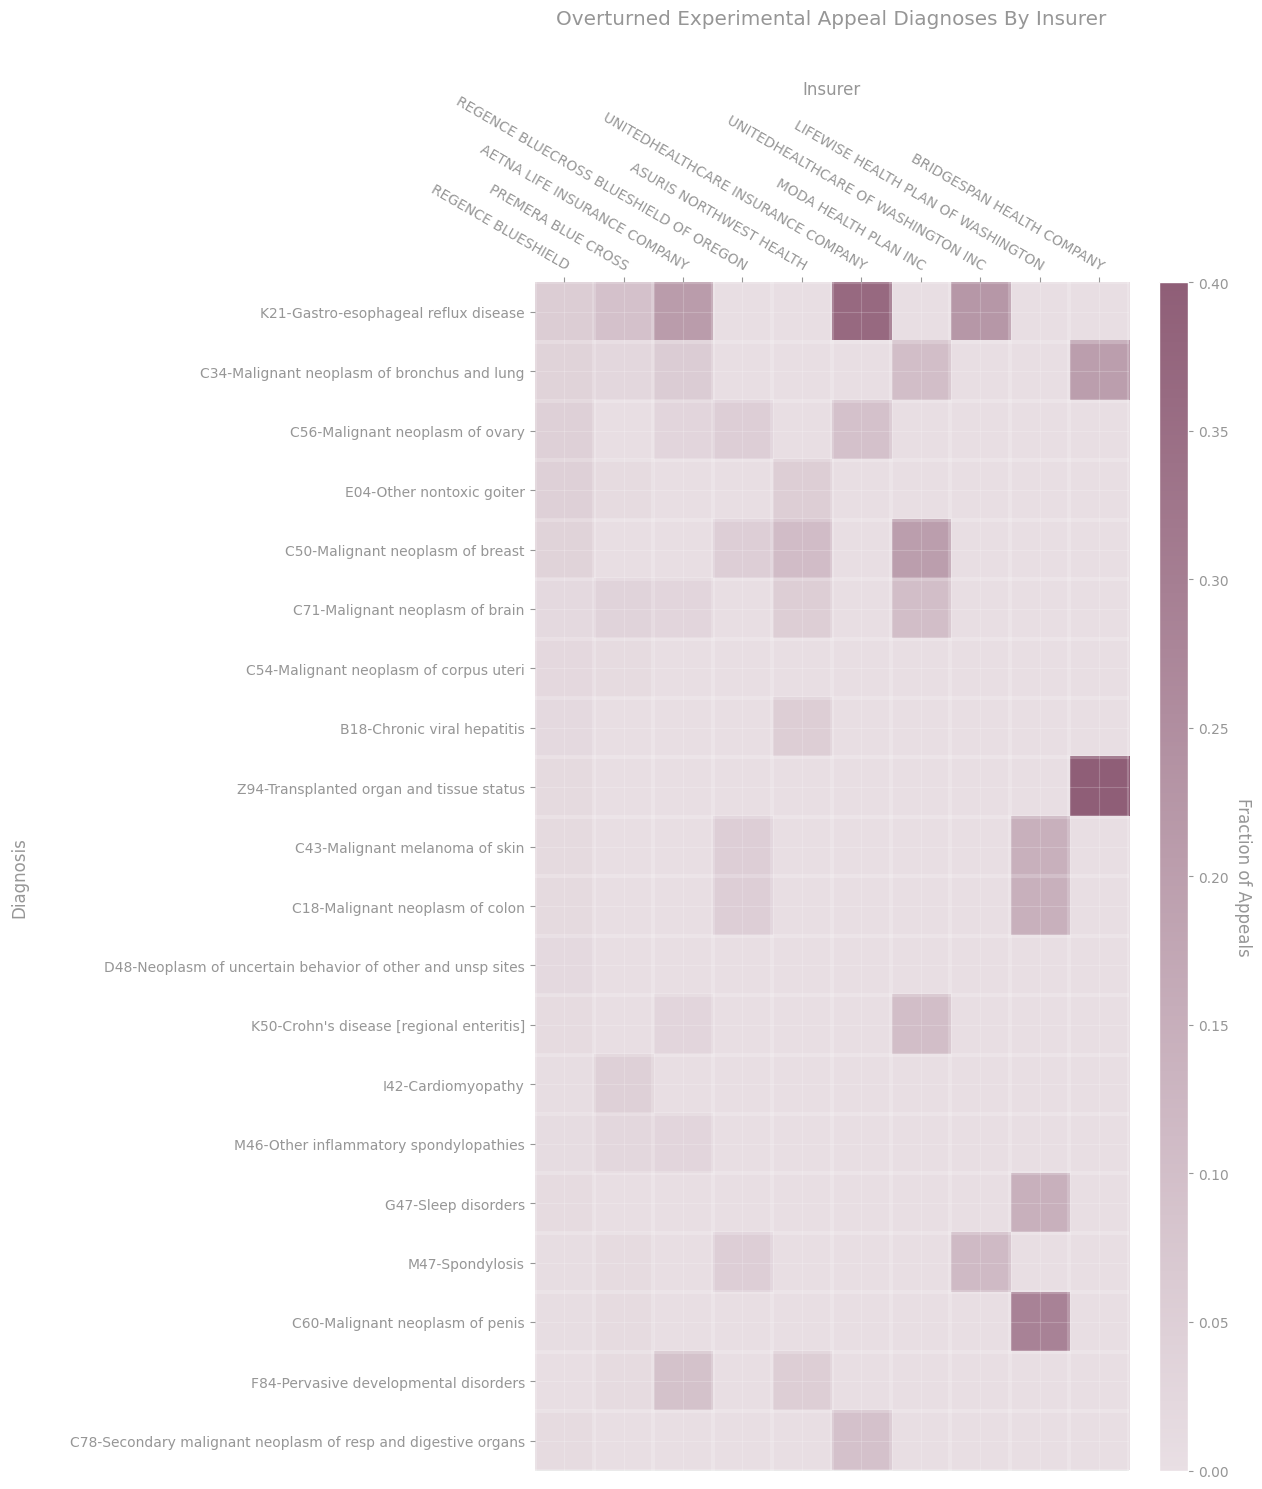

In [46]:
heatmap_from_df_cols(
    overturned_experimental,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Overturned Experimental Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "overturned_experimental_diagnosis_by_insurer.png"
    ),
)

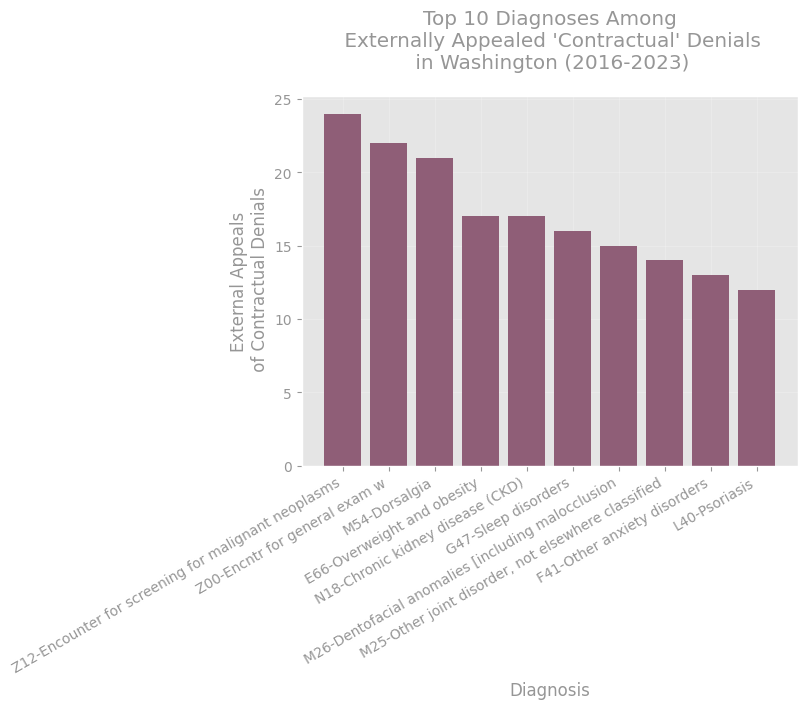

In [47]:
# Diagnosis breakdowns among Contractual Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Contractual' Denials\n in Washington (2016-2023)"
val_axis_label = "External Appeals\n of Contractual Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = contractual["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]").split("/")[0] for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_contractual_appeal_diagnoses.png"),
)

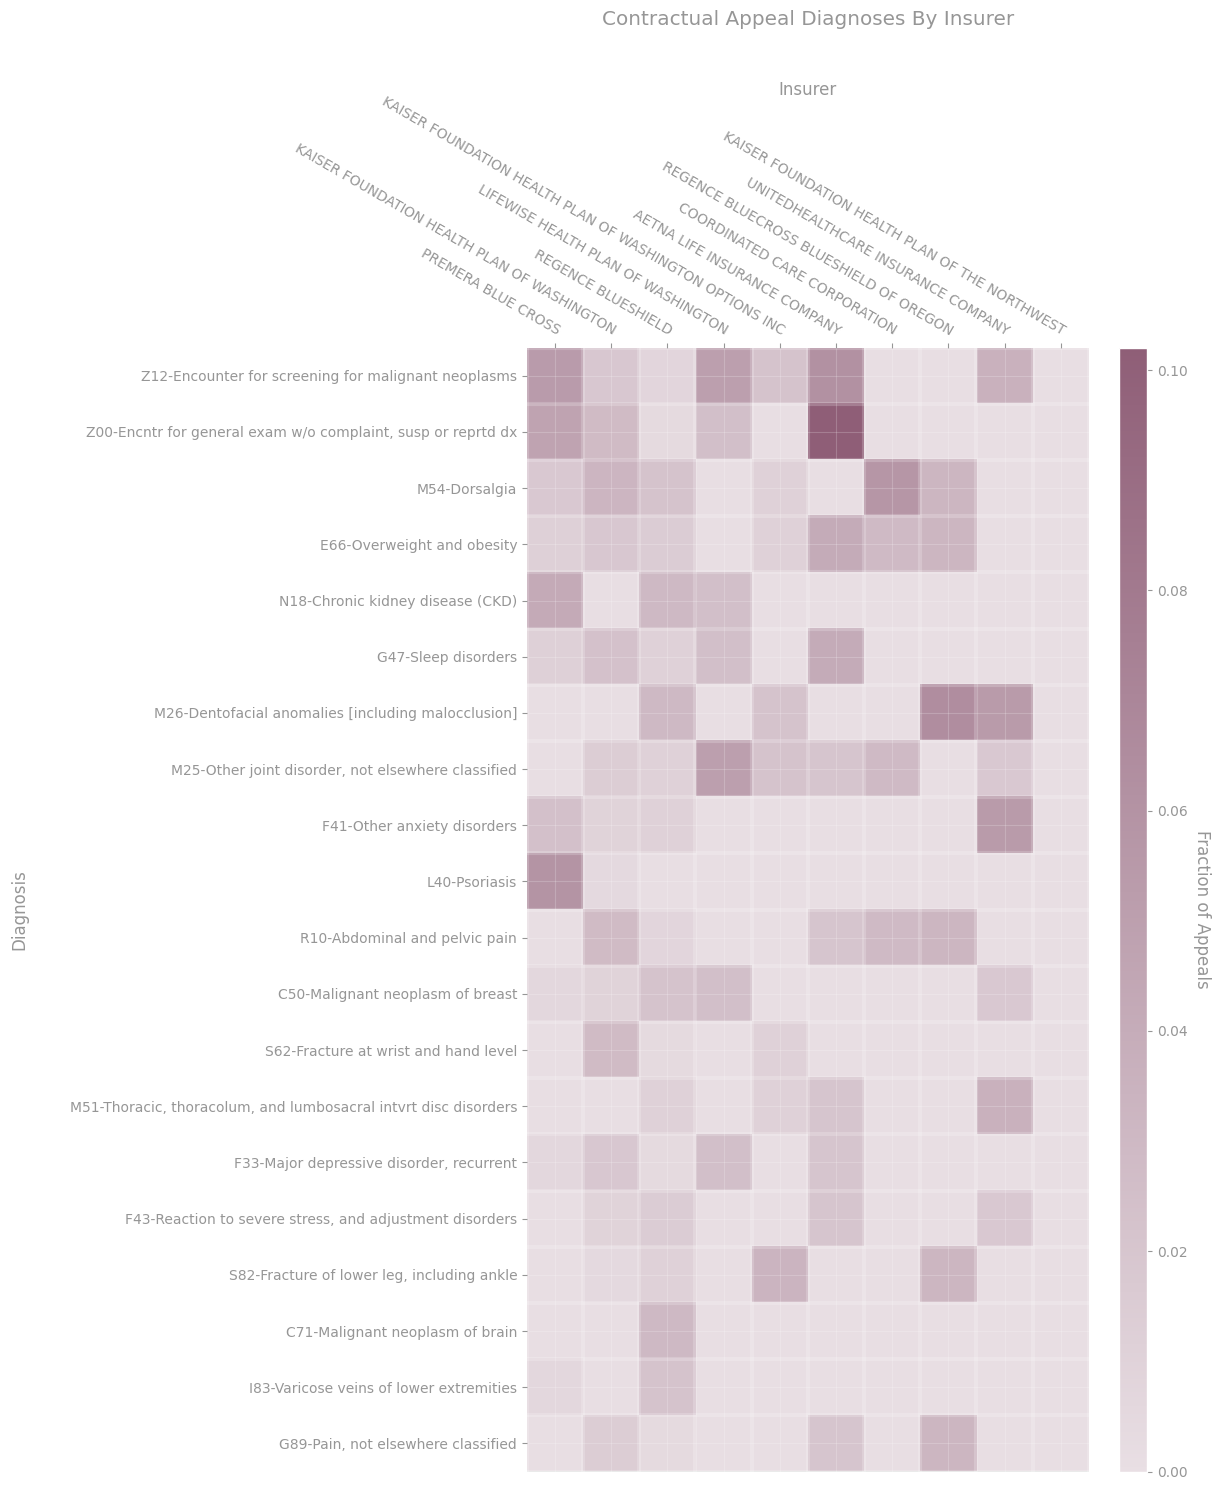

In [48]:
heatmap_from_df_cols(
    contractual,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Contractual Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "contractual_diagnosis_by_insurer.png"),
)

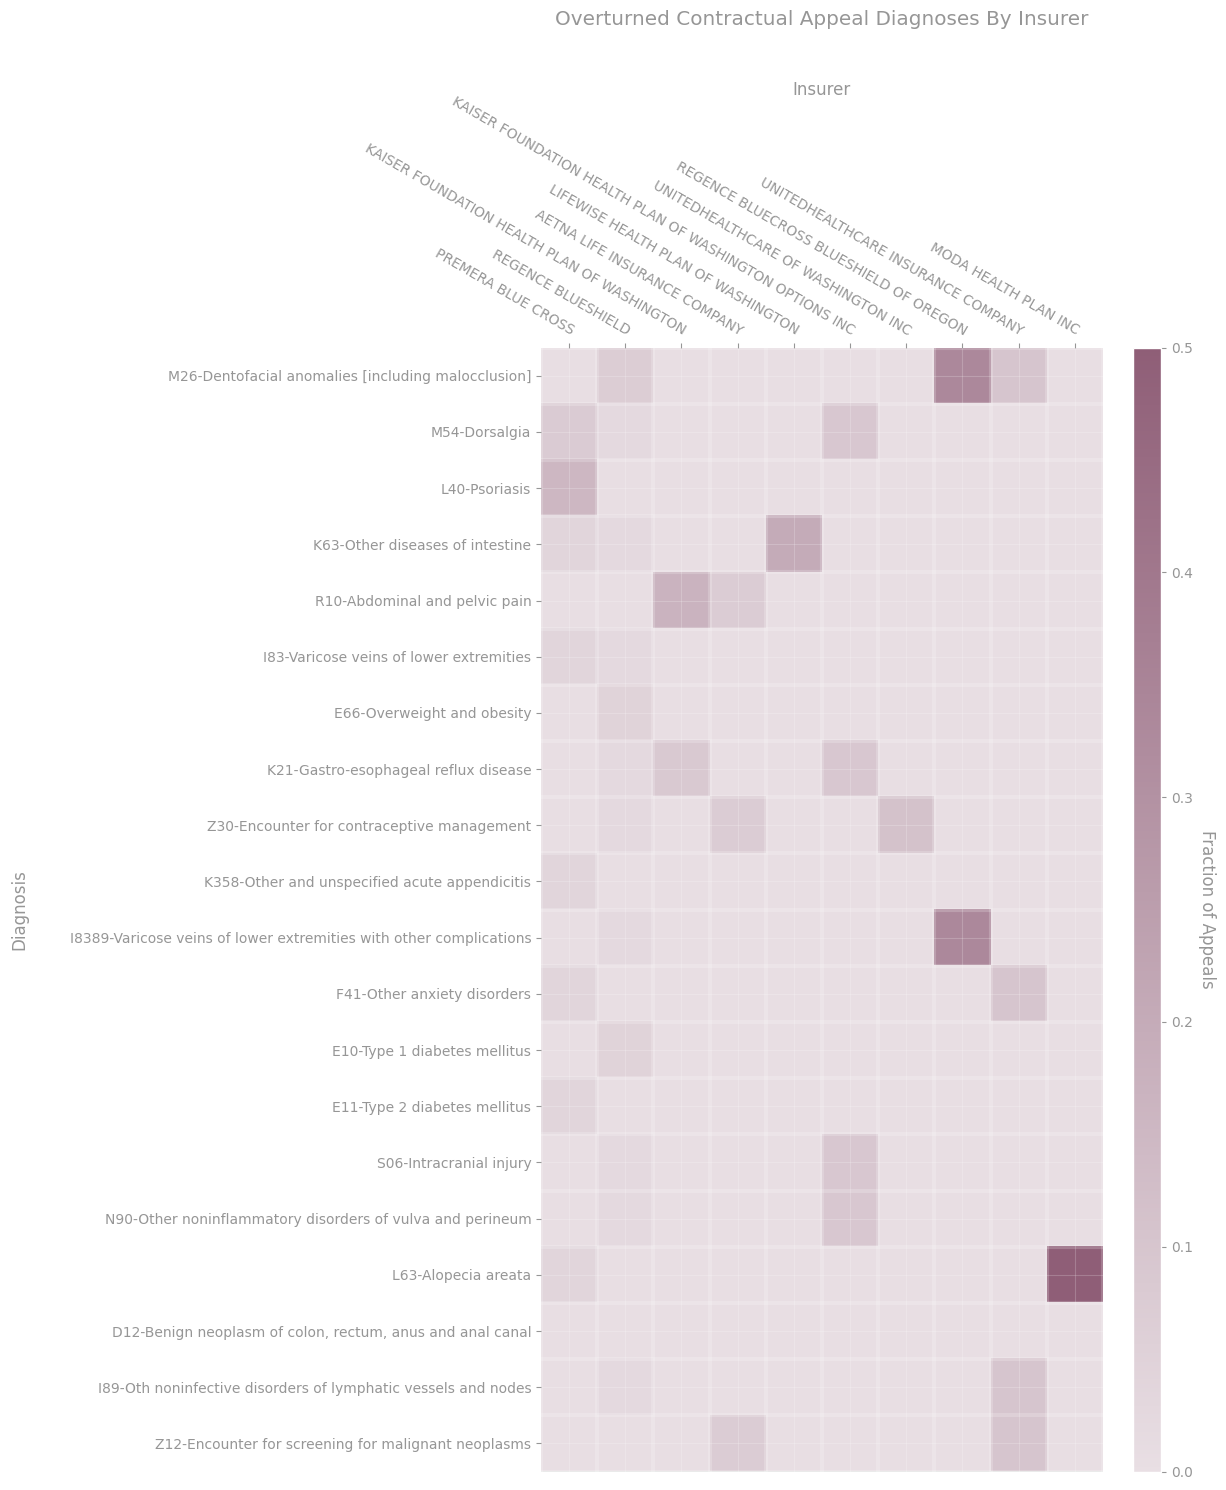

In [49]:
heatmap_from_df_cols(
    overturned_contractual,
    col1="Diagnosis",
    col2="CompanyName",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Overturned Contractual Appeal Diagnoses By Insurer",
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "overturned_contractual_diagnosis_by_insurer.png"
    ),
)

### Breakdown by age

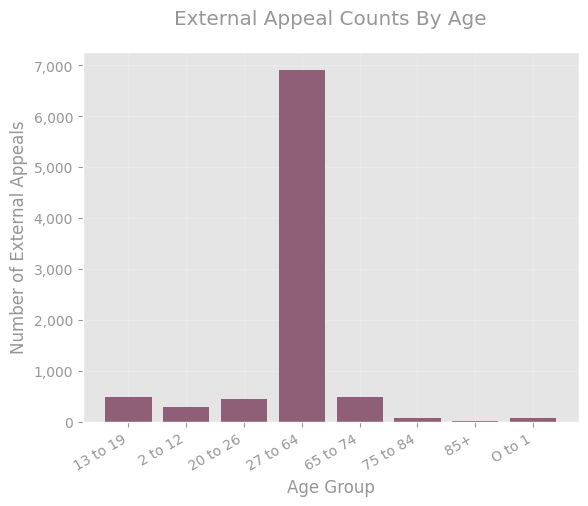

In [50]:
appeals_by_age = df["Age Range"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeal Counts By Age"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
)

### Breakdown by Gender

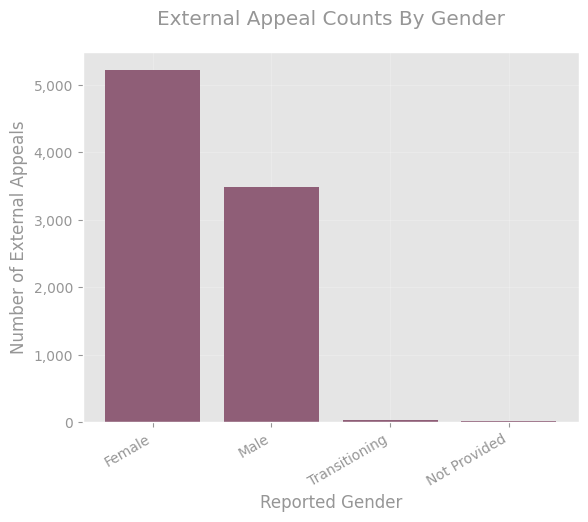

In [51]:
appeals_by_age = df["Gender"].value_counts()
bar_names, bar_vals = list(appeals_by_age.index), appeals_by_age.values
title = "External Appeal Counts By Gender"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
)